# How do lesions to NCM affect performance in this memory task?

We look at (1) overall odds ratio during full test days (Song 8v8 and DC 6v6) before and after lesion, and (2) the effect of the lesion on learning curves.

## Contents

1. Change in odds ratios as a function of lesion size
  - songs
  - dcs
2. Effect of lesions on first (2) informative trials
3. Effect of lesions on learning curves

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "..", "code"))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

from load_data import (
    load_behavioral_data,
    load_lesion_data
)
from plotting import border, set_oddsratio_yticks
from stats import (
    bootstrap,
    fisher_exact,
    get_odds_ratio_matrix,
    jackknife,
    linreg,
)

%load_ext autoreload
%autoreload 2

In [2]:
trial_data = load_behavioral_data()

In [3]:
lesion_data = load_lesion_data()

## 1. Show overall odds ratios as a function of lesion size

### First, summarize overall performance as an odds ratio

This code taken nearly verbatim from https://github.com/theunissenlab/zebra-finch-memory

In [4]:
performance_df_rows = []
for subject in lesion_data["Subject"]:
    subject_df = trial_data[
        (trial_data["Subject"] == subject)
    ]
    
    for ctx, condition in [
                ("SovsSo_8v8_d2", "PrelesionSet1"),
                ("DCvsDC_6v6_d2", "PrelesionSet1"),
                ("SovsSo_8v8_d2", "PostlesionSet1"),
                ("DCvsDC_6v6_d2", "PostlesionSet1"),
                ("SovsSo_8v8_d2_S2", "PostlesionSet2"),
                ("DCvsDC_6v6_d2_S2", "PostlesionSet2"),
            ]:
        ctx_df = subject_df[(subject_df["Test Context"] == ctx) & (subject_df["Ladder Group"] == condition)]

        rewarded_set = ctx_df[ctx_df["Stimulus Class"] == "Rewarded"]
        nonrewarded_set = ctx_df[ctx_df["Stimulus Class"] == "Nonrewarded"]

        table = get_odds_ratio_matrix(nonrewarded_set, rewarded_set, "Interrupt")
        odds, interval95, p_value = fisher_exact(table, side="greater")
        se_logor = np.sqrt(
            np.sum(1 / table)
        )

        performance_df_rows.append(
            [
                subject, ctx, condition, odds, interval95[0], interval95[1], np.log(odds), se_logor, p_value, 
            ]
        )

performance_df = pd.DataFrame(
    performance_df_rows,
    columns=["Subject", "Test Context", "Ladder Group", "Odds Ratio", "95 CI Lower", "95 CI Upper", "LogOR", "SE(LogOR)", "p-value"]
)

In [5]:
lesions_by_performance_df = lesion_data.merge(performance_df, on="Subject")

In [6]:
lesions_by_performance_df.head(10)

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected,Test Context,Ladder Group,Odds Ratio,95 CI Lower,95 CI Upper,LogOR,SE(LogOR),p-value
0,GraWhi4040F,2019-06-25,76082075,253347900,329429975,False,SovsSo_8v8_d2,PrelesionSet1,8.372638,5.463430,inf,2.124969,0.262190,6.881266e-22
1,GraWhi4040F,2019-06-25,76082075,253347900,329429975,False,DCvsDC_6v6_d2,PrelesionSet1,9.013190,6.519035,inf,2.198689,0.197821,1.052477e-34
2,GraWhi4040F,2019-06-25,76082075,253347900,329429975,False,SovsSo_8v8_d2,PostlesionSet1,2.474424,1.873942,inf,0.906008,0.169541,1.377995e-08
3,GraWhi4040F,2019-06-25,76082075,253347900,329429975,False,DCvsDC_6v6_d2,PostlesionSet1,2.979033,2.274227,inf,1.091599,0.164532,5.639628e-12
4,GraWhi4040F,2019-06-25,76082075,253347900,329429975,False,SovsSo_8v8_d2_S2,PostlesionSet2,4.369207,3.162899,inf,1.474581,0.197195,2.683568e-15
5,GraWhi4040F,2019-06-25,76082075,253347900,329429975,False,DCvsDC_6v6_d2_S2,PostlesionSet2,3.950162,3.016068,inf,1.373757,0.164403,1.222543e-17
6,XXXHpi0038M,2019-06-26,147836250,63015600,210851850,False,SovsSo_8v8_d2,PrelesionSet1,18.913151,12.587575,inf,2.939857,0.249287,4.851571e-42
7,XXXHpi0038M,2019-06-26,147836250,63015600,210851850,False,DCvsDC_6v6_d2,PrelesionSet1,12.717170,9.702200,inf,2.542953,0.164922,8.018391e-63
8,XXXHpi0038M,2019-06-26,147836250,63015600,210851850,False,SovsSo_8v8_d2,PostlesionSet1,22.538041,14.732104,inf,3.115205,0.260764,6.334177e-46
9,XXXHpi0038M,2019-06-26,147836250,63015600,210851850,False,DCvsDC_6v6_d2,PostlesionSet1,13.138754,8.017707,inf,2.575566,0.304032,2.192383e-23


### Summarize effect of lesion as ratio between post- and pre-lesion odds ratios

The Total_Lesion_Size column is measured in cubic microns - convert it to cubic mm in the new table.

In [7]:
# Collapse the rows belonging to the same test context by subject

results = []
ladder_set_grouper = lesions_by_performance_df[
    lesions_by_performance_df["Ladder Group"] == "PostlesionSet1"
].groupby(["Subject", "Test Context"])

for (subject, ctx), subj_df in ladder_set_grouper:
    prelesion_OR = lesions_by_performance_df[
        (lesions_by_performance_df["Subject"] == subject)
        & (lesions_by_performance_df["Ladder Group"] == "PrelesionSet1")
        & (lesions_by_performance_df["Test Context"] == ctx)
    ].iloc[0]["Odds Ratio"]
    postlesion_OR = subj_df[subj_df["Ladder Group"] == "PostlesionSet1"].iloc[0]["Odds Ratio"]
    
    results.append({
        "call_type": "So" if ctx == "SovsSo_8v8_d2" else "DC",
        "OR_ratio": postlesion_OR / prelesion_OR,
        "Lesion": subj_df.iloc[0]["Total_Lesion_Size"] * 1e-9
    })
results = pd.DataFrame(results)

In [8]:
def overlay_regression(x, lin, r_adj, cc, ax=None):
    if ax is None:
        ax = plt.gca()
        
    xarr = np.linspace(np.min(x), np.max(x) * 1.1, 3)
    ax.plot(xarr, 2 ** lin(xarr), color="Grey", linestyle="--")
    ax.text(
        1,
        1,
        "$R^2_{{adj}} = {:.2f}$\n$CC = {:.2f}$".format(r_adj, cc), 
        verticalalignment="top", 
        horizontalalignment="right",
        transform=ax.transAxes
    )

def lesion_analysis(df, ax=None):
    """Plot and regress the odds ratio vs lesion volume
    """
    if ax is None:
        ax = plt.gca()

    # Do a linear regression
    popt, pcov, lin, r_squared, r_adj, sigma_ab = linreg(df["Lesion"], np.log2(df["OR_ratio"]))
    cc, _ = pearsonr(df["Lesion"], np.log2(df["OR_ratio"]))
    
    ax.scatter(
        df["Lesion"],
        df["OR_ratio"],
        color="Black",
        s=80
    )
    
    # Plot best fit line
    overlay_regression(df["Lesion"], lin, r_adj, cc, ax=ax)
    ax.set_ylabel(r"$\frac{OR_{post}}{OR_{pre}}$", fontsize=24, rotation=0, verticalalignment="center", horizontalalignment="right")
    ax.set_xlabel("Lesion Size ($mm^3$)", fontsize=20)
    border(ax, 1, 0, 0, 1)
    return r_adj, cc

### Small effect of NCM lesion size on Song performance

$OR_{pre}$ is the odds ratio as measured on the last 2 days of the (5-day) ladder without lesion, when the subjects were tested on 8v8 songs. $OR_{post}$ is the odds ratio measured after surgery/lesion during which the subjects were tested on the same 8v8 set. This typically is approximately 1 or 2 weeks after the $OR_{pre}$ was measured. After surgery/lesion and a short recovery period, they get 1 day of refresher on one stim from the set (1v1) and then 2 days of the 8v8 set. The odds ratio is only measured on the 8v8 days.

Lesion sizes were estimated by a researcher in histological slices. This researcher was blinded to the experimental condition of each subject.

The $R^2$ and correlation coefficient are measured with linear regression, modeling $\log_2(\frac{OR_{post}}{OR_{pre}}) = a V_{lesion} + b$

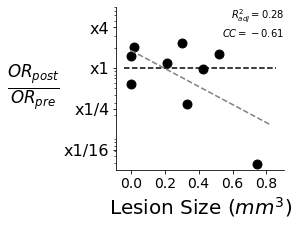

In [9]:
fig = plt.figure(figsize=(3, 3))
r_adj, cc = lesion_analysis(results.query("call_type == 'So'"))
plt.xticks(fontsize=14)
set_oddsratio_yticks(plt.gca(), 3, -5, set_label=False)
plt.show()
plt.close(fig)

### Strong effect of NCM lesion size on DC performance

$OR_{pre}$ is the odds ratio as measured on the last 2 days of the (5-day) ladder without lesion, when the subjects were tested on 6v6 DCs. $OR_{post}$ is the odds ratio measured after surgery/lesion during which the subjects were tested on the same 6v6 set. This typically is approximately 1 or 2 weeks after the $OR_{pre}$ was measured. After surgery/lesion and a short recovery period, they get 1 day of refresher on one stim from the set (1v1) and then 2 days of the 6v6 set. The odds ratio is only measured on the 6v6 days.

Lesion sizes were estimated by a researcher in histological slices. This researcher was blinded to the experimental condition of each subject.

The $R^2$ and correlation coefficient are measured with linear regression, modeling $\log_2(\frac{OR_{post}}{OR_{pre}}) = a V_{lesion} + b$

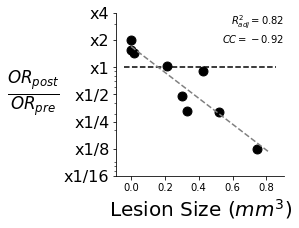

In [10]:
fig = plt.figure(figsize=(3, 3))
r_adj, cc = lesion_analysis(results.query("call_type == 'DC'"))
set_oddsratio_yticks(plt.gca(), 2, -4, set_label=False)
plt.show()
plt.close(fig)

### Learning new set after lesion

After being retested on the stimulus sets from before lesion for 1 week (3 days Songs, 3 days DCs), the subjects were then tested on two new ladders, 8v8 songs S2 (set 2) and 6v6 DCs S2. Each ladder was one additional week, and none of the stimuli were previously presented or heard by the subjects before.

In [11]:
# Collapse the rows belonging to the same test context by subject

new_set_results = []
ladder_set_grouper = lesions_by_performance_df[
    lesions_by_performance_df["Ladder Group"] == "PostlesionSet2"
].groupby(["Subject", "Test Context"])

for (subject, ctx), subj_df in ladder_set_grouper:
    assert ctx.endswith("S2")
    prelesion_OR = lesions_by_performance_df[
        (lesions_by_performance_df["Subject"] == subject)
        & (lesions_by_performance_df["Ladder Group"] == "PrelesionSet1")
        & (lesions_by_performance_df["Test Context"] == ctx[:-3])  # Strip the _S2 from end of ctx
    ].iloc[0]["Odds Ratio"]
    postlesion_OR = subj_df[subj_df["Ladder Group"] == "PostlesionSet2"].iloc[0]["Odds Ratio"]
    
    new_set_results.append({
        "call_type": "So" if ctx == "SovsSo_8v8_d2_S2" else "DC",
        "OR_ratio": postlesion_OR / prelesion_OR,
        "Lesion": subj_df.iloc[0]["Total_Lesion_Size"] / 1e-9
    })
new_set_results = pd.DataFrame(new_set_results)

### New songs set after lesion

$OR_{pre}$ is the odds ratio as measured on the last 2 days of the (5-day) ladder without lesion, when the subjects were tested on a set of 8v8 songs (S1). $OR_{new}$ is the odds ratio measured on the last 2 days of a new (5-day) ladder (S2) after surgery/lesion, with a different set of 8v8 songs. This typically is approximately 3 or 4 weeks after the $OR_{pre}$ was measured.

The $R^2$ and correlation coefficient are measured with linear regression, modeling $\log_2(\frac{OR_{S2,les}}{OR_{S1}}) = a V_{lesion} + b$

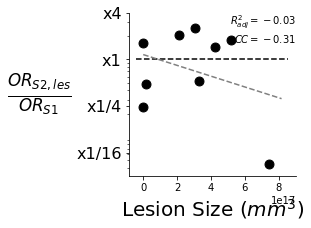

In [12]:
fig = plt.figure(figsize=(3, 3))
r_adj, cc = lesion_analysis(new_set_results.query("call_type == 'So'"))
set_oddsratio_yticks(plt.gca(), 2, -5, set_label=False)
plt.gca().set_ylabel(r"$\frac{OR_{S2,les}}{OR_{S1}}$", fontsize=24, rotation=0, verticalalignment="center", horizontalalignment="right")
plt.show()
plt.close(fig)

### New DCs set after lesion

$OR_{S1}$ is the odds ratio as measured on the last 2 days of the (5-day) ladder without lesion, when the subjects were tested on a set of 6v6 DCs (S1). $OR_{S2,les}$ is the odds ratio measured on the last 2 days of a new (5-day) ladder (S2) after surgery/lesion, with a different set of 6v6 DCs. This typically is approximately 3 or 4 weeks after the $OR_{S1}$ was measured.

The $R^2$ and correlation coefficient are measured with linear regression, modeling $\log_2(\frac{OR_{S2,les}}{OR_{S1}}) = a V_{lesion} + b$

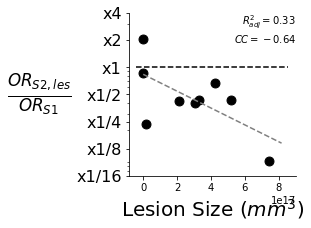

In [13]:
fig = plt.figure(figsize=(3, 3))
r_adj, cc = lesion_analysis(new_set_results.query("call_type == 'DC'"))
set_oddsratio_yticks(plt.gca(), 2, -4)
plt.gca().set_ylabel(r"$\frac{OR_{S2,les}}{OR_{S1}}$", fontsize=24, rotation=0, verticalalignment="center", horizontalalignment="right")
plt.show()
plt.close(fig)

## 2. Show if lesions have an effect on first exposures

Again, informative trial code based on learning curve code from https://github.com/theunissenlab/zebra-finch-memory

Learning curves plotted as an odds ratio between interrupting nonrewarded and rewarded vocalizers are generated as an average across subjects.

In [14]:
def inject_relative_informative_trials(df):
    """Takes a dataframe with a subset of trials and injects a column of "Relative Informative Trials Seen"
    which indicates the number of informative trials seen by a subject for a given vocalizer in the
    selected range
    """
    df = df.copy()
    df["Relative Informative Trials Seen"] = df["Informative Trials Seen"]
    for (subj, vocalizer, call_type), subdf in df.groupby(["Subject", "Stimulus Vocalizer", "Stimulus Call Type"]):
        df.loc[
            subdf.index,
            "Relative Informative Trials Seen"
        ] -= subdf.iloc[0]["Informative Trials Seen"]
    
    return df

def generate_informative_trial_dataframe(df, informative_trials):
    """Generate a dataframe with interruption data per bin per subject per stimulus
    from the selected trials
    """
    # The "Informative Trials Seen" column counts informative trials seen for a given stim across
    # all sessions run for a subject. The given dataframe may only include trials from a selected
    # epoch which may not include the first sessions. So we create a new "Relative Informative Trials Seen"
    # column that shows number of informative trials seen relative to the start of the requested range.
    df = inject_relative_informative_trials(df)
    output_rows = []
    for bin_idx in informative_trials:
        bin_df = df[df["Relative Informative Trials Seen"] == bin_idx]
        for (subject, subject_sex, vocalizer, call_type, rewarded), stim_df in bin_df.groupby([
                    "Subject", "Subject Sex", "Stimulus Vocalizer", "Stimulus Call Type", "Stimulus Class"
                ]):
            output_rows.append([
                subject,
                subject_sex,
                vocalizer,
                call_type,
                rewarded,
                bin_idx,
                len(stim_df),
                np.mean(stim_df["Interrupt"])  # This should be just 1 / len(stim_df)
            ])
            
    return pd.DataFrame(output_rows, columns=["Subject", "Subject Sex", "Stimulus Vocalizer", "Stimulus Call Type",
            "Stimulus Class", "Relative Informative Trials Seen", "Bin Size", "p(interrupt)"])

def process_first_n_informative_trials(df, n=2):
    """Assess interruption rates and odds ratio in first n informative trials (inclusive)
    """
    inform_df = generate_informative_trial_dataframe(df, np.arange(3))
    # The following line ensures that we bin 0&1 into bin 0, 2&3 into bin 2, etc
    subdf = inform_df[inform_df["Relative Informative Trials Seen"] <= n]
    re = subdf[subdf["Stimulus Class"] == "Rewarded"]
    nore = subdf[subdf["Stimulus Class"] == "Nonrewarded"]
    
    if not len(re):
        raise ValueError("No rewarded stimuli found")
    if not len(nore):
        raise ValueError("No nonrewarded stimuli found")

    if len(re) != len(nore):
        raise Exception("Different number of rewarded stimuli than nonrewarded")

    p_re, sem_re = jackknife(re["p(interrupt)"], np.mean)
    p_nore, sem_nore = jackknife(nore["p(interrupt)"], np.mean)

    if p_re == 0:
        p_re = 0.5 / len(re["p(interrupt)"])

    if p_nore == 0:
        p_nore = 0.5 / len(nore["p(interrupt)"])

    def _logor(p_re, p_nore):
        p_re = np.mean(p_re)
        p_nore = np.mean(p_nore)

        if p_re == 0:
            p_re = 0.5 / len(re["p(interrupt)"])

        if p_nore == 0:
            p_nore = 0.5 / len(nore["p(interrupt)"])

        return np.log2(p_nore / (1 - p_nore)) - np.log2(p_re / (1 - p_re))

    logor = _logor(re["p(interrupt)"], nore["p(interrupt)"])
    logor_sem = bootstrap(_logor, re["p(interrupt)"], nore["p(interrupt)"])
    
    return {
        "p_re": p_re,
        "p_nore": p_nore,
        "sem_re": sem_re,
        "sem_nore": sem_nore,
        "logor": logor,
        "logor_sem": logor_sem
    }

In [15]:
valid_subjects = lesion_data["Subject"]

In [16]:
song_prelesion_early = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1") &
    (trial_data["Stimulus Call Type"] == "SO")
]
song_prelesion_late = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1") &
    (trial_data["Stimulus Call Type"] == "SO") &
    (trial_data["Test Context"] == "SovsSo_8v8_d2")
]
song_postlesion_early = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet1") &
    (trial_data["Stimulus Call Type"] == "SO")
]
song_postlesion_set2_early = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet2") &
    (trial_data["Stimulus Call Type"] == "SO")
]
song_postlesion_set2_late = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet2") &
    (trial_data["Stimulus Call Type"] == "SO") &
    (trial_data["Test Context"] == "SovsSo_8v8_d2_S2")
]

dc_prelesion_early = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1") &
    (trial_data["Stimulus Call Type"] == "DC")
]
dc_prelesion_late = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1") &
    (trial_data["Stimulus Call Type"] == "DC") &
    (trial_data["Test Context"] == "DCvsDC_6v6_d2")
]
dc_postlesion_early = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet1") &
    (trial_data["Stimulus Call Type"] == "DC")
]
dc_postlesion_set2_early = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet2") &
    (trial_data["Stimulus Call Type"] == "DC")
]
dc_postlesion_set2_late = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet2") &
    (trial_data["Stimulus Call Type"] == "DC") &
    (trial_data["Test Context"] == "DCvsDC_6v6_d2_S2")
]

## Plot the log odds ratio of first 2 informative trials pre and post lesion

The first comparisons are prelesion S1 late versus postlesion S1 early. By limiting this to the first 2 informative trials (inclusive) This represents recall after lesion before there is a chance to relearn.

The second comparison is and prelesion S1 early vs postlesion S2 early. If we limit the informative trials to something small but not too small (like, 4 informative trials?) is a proxy measure for how quickly stimuli can be learned.

The values I will report is $2^{log_2{OR_{post}} - log_2{OR_{pre}}} = 2^{log_2{\frac{OR_{post}}{OR_{pre}}}} = \frac{OR_{post}}{OR_{pre}}$ (plotted on a log scale)

In [17]:
song_set1_scatter_points = []
for subject in valid_subjects:
#     display(lesion_data[lesion_data["Subject"] == subject])
    row = lesion_data[lesion_data["Subject"] == subject].iloc[0]
    
    prelesion_data = process_first_n_informative_trials(
        song_prelesion_late[song_prelesion_late["Subject"] == subject],
        2
    )
    postlesion_data = process_first_n_informative_trials(
        song_postlesion_early[song_postlesion_early["Subject"] == subject],
        2
    )
    
    song_set1_scatter_points.append((
        row["Total_Lesion_Size"] / 1e9,
        2 ** (postlesion_data["logor"] - prelesion_data["logor"])
    ))

song_set2_scatter_points = []
for subject in valid_subjects:
#     display(lesion_data[lesion_data["Subject"] == subject])
    row = lesion_data[lesion_data["Subject"] == subject].iloc[0]
    
    prelesion_data = process_first_n_informative_trials(
        song_prelesion_early[song_prelesion_early["Subject"] == subject],
        4
    )
    postlesion_data = process_first_n_informative_trials(
        song_postlesion_set2_early[song_postlesion_set2_early["Subject"] == subject],
        4
    )
    
    song_set2_scatter_points.append((
        row["Total_Lesion_Size"] / 1e9,
        2 ** (postlesion_data["logor"] - prelesion_data["logor"])
    ))

In [18]:
dc_set1_scatter_points = []
for subject in valid_subjects:
#     display(lesion_data[lesion_data["Subject"] == subject])
    row = lesion_data[lesion_data["Subject"] == subject].iloc[0]
    
    prelesion_data = process_first_n_informative_trials(
        dc_prelesion_late[dc_prelesion_late["Subject"] == subject],
        2
    )
    postlesion_data = process_first_n_informative_trials(
        dc_postlesion_early[dc_postlesion_early["Subject"] == subject],
        2
    )
    
    dc_set1_scatter_points.append((
        row["Total_Lesion_Size"] / 1e9,
        2 ** (postlesion_data["logor"] - prelesion_data["logor"])
    ))

dc_set2_scatter_points = []
for subject in valid_subjects:
#     display(lesion_data[lesion_data["Subject"] == subject])
    row = lesion_data[lesion_data["Subject"] == subject].iloc[0]
    
    prelesion_data = process_first_n_informative_trials(
        dc_prelesion_early[dc_prelesion_early["Subject"] == subject],
        4
    )
    postlesion_data = process_first_n_informative_trials(
        dc_postlesion_set2_early[dc_postlesion_set2_early["Subject"] == subject],
        4
    )
    
    dc_set2_scatter_points.append((
        row["Total_Lesion_Size"] / 1e9,
        2 ** (postlesion_data["logor"] - prelesion_data["logor"])
    ))

### 1 Songs Recall

This plot shows the performance on the first two informative trials (inclusive) during recall of S1 after lesion. $OR_{S1,pre,late}$ is the odds ratio as measured during the first two inforamtive trials (per stimulus vocalizer) starting from the full 8v8 songs d2. This is after they have had 1-3 days of experiece with the stimuli previously. $OR_{S1,post,early}$ is the odds ratio as measured during the first two informative trials after lesion, with no reinforcement between lesion time and the counting of informative trials. Thus this is performance on the previously learned stimuli without any opportunity for relearning.

The ratio of these measures how much did their performance drop between lesion + recovery time.

The $R^2$ and correlation coefficient are measured with linear regression, modeling $\log_2(\frac{OR_{S1,post,early}}{OR_{S1,pre,late}}) = a V_{lesion} + b$, where, again, the ORs are measured only during the first two informative trials per stim (inclusive).

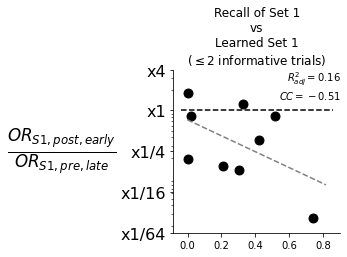

In [19]:
fig = plt.figure(figsize=(3, 3))
plt.scatter(*zip(*song_set1_scatter_points), color="Black", s=80)

X, Y = np.array([[x, np.log2(y)] for x, y in song_set1_scatter_points]).T
popt, pcov, lin, r_squared, r_adj, sigma_ab = linreg(X, Y)
cc, _ = pearsonr(X, Y)
overlay_regression(X, lin, r_adj, cc)

set_oddsratio_yticks(plt.gca(), 2, -6, set_label=False)
border(plt.gca(), 1, 0, 0, 1)
plt.title("Recall of Set 1\nvs\nLearned Set 1\n(" + r"$\leq 2$" + " informative trials)")
plt.gca().set_ylabel(r"$\frac{OR_{S1,post,early}}{OR_{S1,pre,late}}$", fontsize=24, rotation=0, verticalalignment="center", horizontalalignment="right")
plt.show()
plt.close(fig)
plt.show()


### 2 DCs Recall

This plot shows the performance on the first two informative trials (inclusive) during recall of S1 after lesion. $OR_{S1,pre,late}$ is the odds ratio as measured during the first two inforamtive trials (per stimulus vocalizer) starting from the full 6v6 DCs d2. This is after they have had 1-3 days of experiece with the stimuli previously. $OR_{S1,post,early}$ is the odds ratio as measured during the first two informative trials after lesion, with no reinforcement between lesion time and the counting of informative trials. Thus this is performance on the previously learned stimuli without any opportunity for relearning.

The ratio of these measures how much did their performance drop between lesion + recovery time.

The $R^2$ and correlation coefficient are measured with linear regression, modeling $\log_2(\frac{OR_{S1,post,early}}{OR_{S1,pre,late}}) = a V_{lesion} + b$, where, again, the ORs are measured only during the first two informative trials per stim (inclusive).

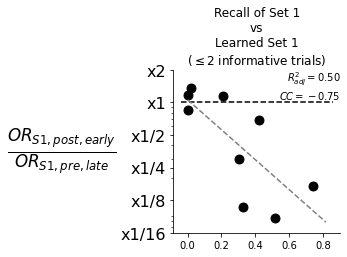

In [20]:
fig = plt.figure(figsize=(3, 3))
plt.scatter(*zip(*dc_set1_scatter_points), color="Black", s=80)

X, Y = np.array([[x, np.log2(y)] for x, y in dc_set1_scatter_points]).T
popt, pcov, lin, r_squared, r_adj, sigma_ab = linreg(X, Y)
cc, _ = pearsonr(X, Y)
overlay_regression(X, lin, r_adj, cc)

set_oddsratio_yticks(plt.gca(), 1, -4, set_label=False)
border(plt.gca(), 1, 0, 0, 1)
plt.title("Recall of Set 1\nvs\nLearned Set 1\n(" + r"$\leq 2$" + " informative trials)")
plt.gca().set_ylabel(r"$\frac{OR_{S1,post,early}}{OR_{S1,pre,late}}$", fontsize=24, rotation=0, verticalalignment="center", horizontalalignment="right")
plt.show()
plt.close(fig)
plt.show()

### 3 Songs new set

This plot shows the performance on the first **four** informative trials (inclusive) during the learning of S1 (before lesion) and S2 (after lesion). $OR_{S1,early}$ is the odds ratio as measured during the first **four** informative trials (per stimulus vocalizer) as the stimuli are being learned for the first time. $OR_{S2,early}$ is the odds ratio as measured during the first **four** informative trials of a new set after lesion (they had not learned this set before lesion).

The ratio of these measures how much better/worse are they learning a new set after lesion versus a new set before lesion. Changes can be caused by several factors, among these that the new set could be easier/harder than the first set, and/or there can be metalearning (the subjects could theoretically get better at the task itself), as well as the experimental factor of the lesion.

The $R^2$ and correlation coefficient are measured with linear regression, modeling $\log_2(\frac{OR_{S2,early}}{OR_{S1,early}}) = a V_{lesion} + b$.

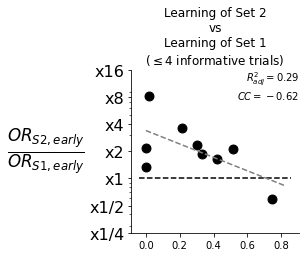

In [21]:
fig = plt.figure(figsize=(3, 3))
plt.scatter(*zip(*song_set2_scatter_points), color="Black", s=80)

X, Y = np.array([[x, np.log2(y)] for x, y in song_set2_scatter_points]).T
popt, pcov, lin, r_squared, r_adj, sigma_ab = linreg(X, Y)
cc, _ = pearsonr(X, Y)
overlay_regression(X, lin, r_adj, cc)

set_oddsratio_yticks(plt.gca(), 4, -2, set_label=False)
border(plt.gca(), 1, 0, 0, 1)
plt.title("Learning of Set 2\nvs\nLearning of Set 1\n(" + r"$\leq 4$" +" informative trials)")
plt.gca().set_ylabel(r"$\frac{OR_{S2,early}}{OR_{S1,early}}$", fontsize=24, rotation=0, verticalalignment="center", horizontalalignment="right")
plt.show()
plt.close(fig)
plt.show()

### 4 DCs new set

This plot shows the performance on the first **four** informative trials (inclusive) during the learning of S1 (before lesion) and S2 (after lesion). $OR_{S1,early}$ is the odds ratio as measured during the first **four** informative trials (per stimulus vocalizer) as the stimuli are being learned for the first time. $OR_{S2,early}$ is the odds ratio as measured during the first **four** informative trials of a new set after lesion (they had not learned this set before lesion).

The ratio of these measures how much better/worse are they learning a new set after lesion versus a new set before lesion. Changes can be caused by several factors, among these that the new set could be easier/harder than the first set, and/or there can be metalearning (the subjects could theoretically get better at the task itself), as well as the experimental factor of the lesion.

The $R^2$ and correlation coefficient are measured with linear regression, modeling $\log_2(\frac{OR_{S2,early}}{OR_{S1,early}}) = a V_{lesion} + b$.

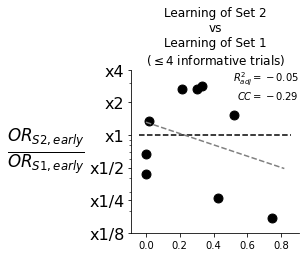

In [22]:
fig = plt.figure(figsize=(3, 3))
plt.scatter(*zip(*dc_set2_scatter_points), color="Black", s=80)

X, Y = np.array([[x, np.log2(y)] for x, y in dc_set2_scatter_points]).T
popt, pcov, lin, r_squared, r_adj, sigma_ab = linreg(X, Y)
cc, _ = pearsonr(X, Y)
overlay_regression(X, lin, r_adj, cc)

set_oddsratio_yticks(plt.gca(), 2, -3, set_label=False)
border(plt.gca(), 1, 0, 0, 1)
plt.title("Learning of Set 2\nvs\nLearning of Set 1\n(" + r"$\leq 4$" +" informative trials)")
plt.gca().set_ylabel(r"$\frac{OR_{S2,early}}{OR_{S1,early}}$", fontsize=24, rotation=0, verticalalignment="center", horizontalalignment="right")
plt.show()
plt.close(fig)
plt.show()